In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# Data processing
raw_df = pd.read_csv('datasets/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
import numpy as np
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Example: \n Total: {}\n Positive:{} ({:.2f}% of total)'.format(total, pos, pos*100/total))

Example: 
 Total: 284807
 Positive:492 (0.17% of total)


In [6]:
cleaned_df = raw_df.copy()

cleaned_df.pop('Time')

eps = 0.001
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+ eps)

In [7]:
# split data
train_df, test_df = train_test_split(cleaned_df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.2)

In [8]:
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
bool_val_labels = val_labels != 0
test_labels = np.array(test_df.pop('Class'))
bool_test_labels = test_labels != 0

In [9]:
train_features = train_df.values
val_features = val_df.values
test_features = test_df.values

In [10]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [11]:
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Text(0.5, 0.98, 'Negative distribution')

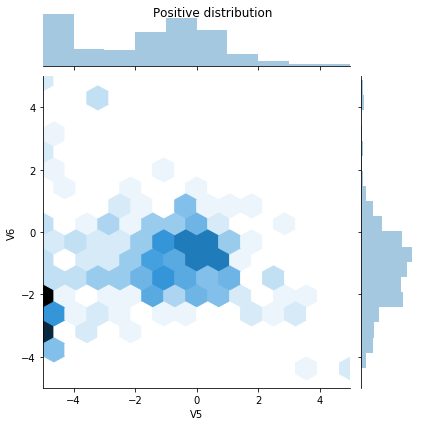

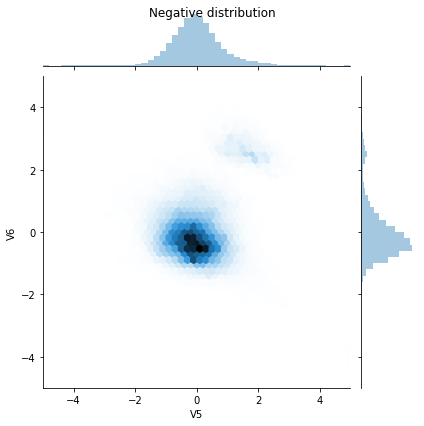

In [12]:
# view the data distribution
pos_df = pd.DataFrame(train_features[bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns) # 取反用~

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Negative distribution")

In [13]:
# Define the model and metrics
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

def build_model(metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
   
    model = keras.Sequential()
    model.add(keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1], ))) # note: input shape should add ,
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias))
    
    model.compile(
        optimizer = 'Adam',
        loss = keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    return model

In [14]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [15]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [16]:
# kapathy tick: 
#If you have an imbalanced dataset of a ratio 1:10 of positives:negatives, 
#set the bias on your logits such that your network predicts probability of 0.1 at initialization. 
# Setting these correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias.
initial_bias = np.log([pos/neg])
initial_bias


array([-6.35935934])

In [17]:
model = build_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00257475],
       [0.00171658],
       [0.00071282],
       [0.00077864],
       [0.0004364 ],
       [0.00102974],
       [0.00159272],
       [0.00339396],
       [0.00174393],
       [0.00116033]], dtype=float32)

In [18]:
#Checkpoint the initial weights
#To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, 
#and load them into each model before training.
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [19]:
model = build_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [20]:
model = build_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
def plot_loss(history, label, n):
    # use a log scale to show the wide range of values
    plt.semilogy(history.epoch, history.history['loss'],
                color=colors[n], label='Train ' + label)
    
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

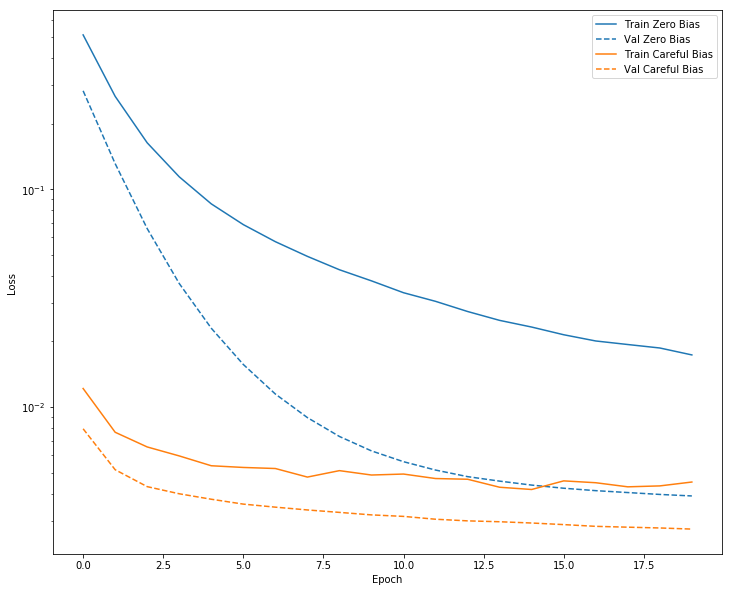

In [22]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)
plt.show()

In [23]:
model = build_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 4s 22us/sample - loss: 0.0123 - tp: 2.0000 - fp: 47.0000 - tn: 181906.0000 - fn: 321.0000 - accuracy: 0.9980 - precision: 0.0408 - recall: 0.0062 - auc: 0.6845 - val_loss: 0.0080 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45495.0000 - val_fn: 74.0000 - val_accuracy: 0.9984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8841
Epoch 2/100
182276/182276 [==============================] - 1s 5us/sample - loss: 0.0081 - tp: 90.0000 - fp: 16.0000 - tn: 181937.0000 - fn: 233.0000 - accuracy: 0.9986 - precision: 0.8491 - recall: 0.2786 - auc: 0.8496 - val_loss: 0.0053 - val_tp: 23.0000 - val_fp: 6.0000 - val_tn: 45489.0000 - val_fn: 51.0000 - val_accuracy: 0.9987 - val_precision: 0.7931 - val_recall: 0.3108 - val_auc: 0.9048
Epoch 3/100
182276/182276 [==============================] - 1s 6us/sample - loss: 0.0063 - tp: 145.0000 - fp: 23.0000 - tn: 181930.00

In [24]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

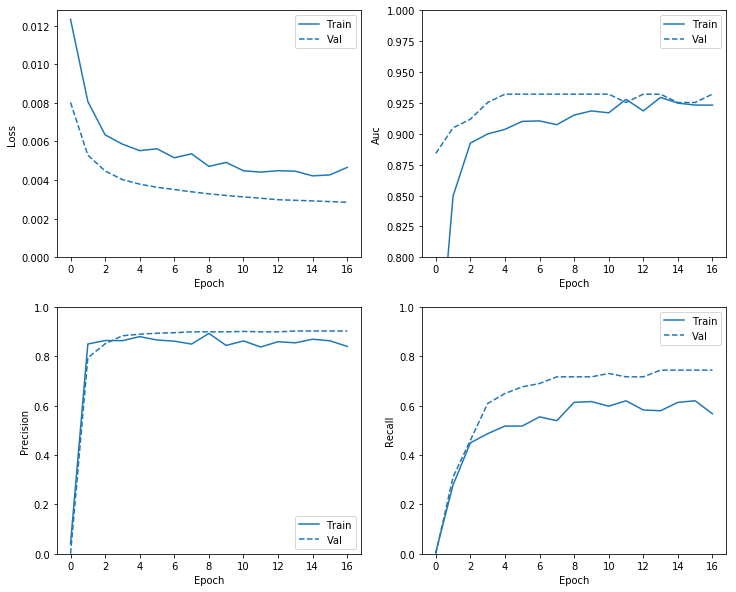

In [25]:
plot_metrics(baseline_history)

In [26]:
# Evaluate metrics (important)
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.003506771688910379
tp :  73.0
fp :  13.0
tn :  56854.0
fn :  22.0
accuracy :  0.99938554
precision :  0.8488372
recall :  0.76842105
auc :  0.94175947


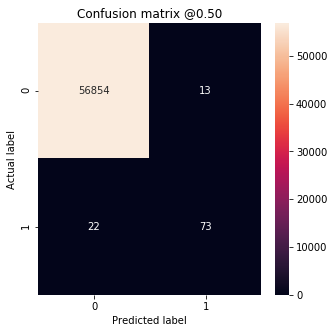

In [28]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

plot_cm(test_labels, test_predictions_baseline)

In [29]:
def plot_roc(name, labels, predictions, **kwargs): # add key-values pairs as input
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs) # usage
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

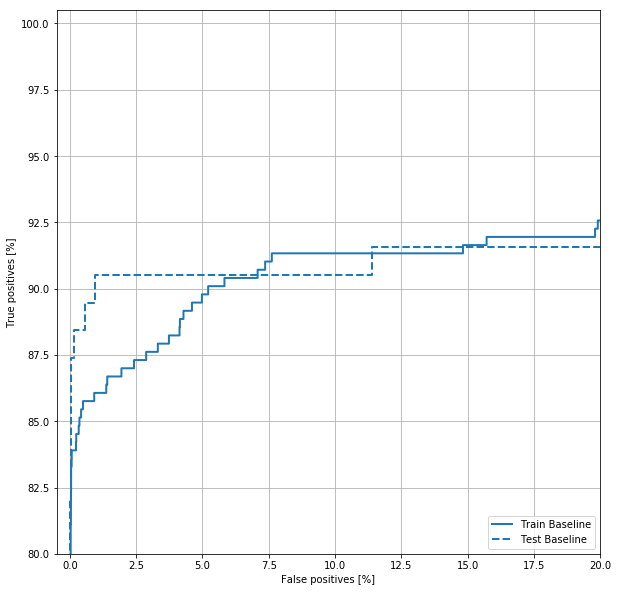

In [30]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [31]:
# Class weights

In [32]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = total/2.0 / neg
weight_for_1 = total/2.0 / pos

# build dict
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [33]:
weighted_model = build_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

W0118 16:49:47.149604 140736764920768 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0118 16:49:47.296173 140736764920768 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 4s 21us/sample - loss: 2.5940 - tp: 14.0000 - fp: 158.0000 - tn: 181795.0000 - fn: 309.0000 - accuracy: 0.9974 - precision: 0.0814 - recall: 0.0433 - auc: 0.7027 - val_loss: 1.5572 - val_tp: 0.0000e+00 - val_fp: 5.0000 - val_tn: 45490.0000 - val_fn: 74.0000 - val_accuracy: 0.9983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9063
Epoch 2/100
182276/182276 [==============================] - 1s 4us/sample - loss: 1.3429 - tp: 102.0000 - fp: 388.0000 - tn: 181565.0000 - fn: 221.0000 - accuracy: 0.9967 - precision: 0.2082 - recall: 0.3158 - auc: 0.8720 - val_loss: 0.5546 - val_tp: 51.0000 - val_fp: 36.0000 - val_tn: 45459.0000 - val_fn: 23.0000 - val_accuracy: 0.9987 - val_precision: 0.5862 - val_recall: 0.6892 - val_auc: 0.9629
Epoch 3/100
182276/182276 [==============================] - 1s 4us/sample - loss: 0.7298 - tp: 195.0000 - fp: 768.0000 - tn: 181185.

182276/182276 [==============================] - 1s 5us/sample - loss: 0.2463 - tp: 286.0000 - fp: 6359.0000 - tn: 175594.0000 - fn: 37.0000 - accuracy: 0.9649 - precision: 0.0430 - recall: 0.8854 - auc: 0.9654 - val_loss: 0.1514 - val_tp: 67.0000 - val_fp: 991.0000 - val_tn: 44504.0000 - val_fn: 7.0000 - val_accuracy: 0.9781 - val_precision: 0.0633 - val_recall: 0.9054 - val_auc: 0.9821
Epoch 22/100
182276/182276 [==============================] - 1s 4us/sample - loss: 0.2275 - tp: 287.0000 - fp: 6570.0000 - tn: 175383.0000 - fn: 36.0000 - accuracy: 0.9638 - precision: 0.0419 - recall: 0.8885 - auc: 0.9670 - val_loss: 0.1518 - val_tp: 67.0000 - val_fp: 1008.0000 - val_tn: 44487.0000 - val_fn: 7.0000 - val_accuracy: 0.9777 - val_precision: 0.0623 - val_recall: 0.9054 - val_auc: 0.9820
Epoch 23/100
182276/182276 [==============================] - 1s 4us/sample - loss: 0.2349 - tp: 286.0000 - fp: 6454.0000 - tn: 175499.0000 - fn: 37.0000 - accuracy: 0.9644 - precision: 0.0424 - recall: 0

182276/182276 [==============================] - 1s 5us/sample - loss: 0.1947 - tp: 292.0000 - fp: 6296.0000 - tn: 175657.0000 - fn: 31.0000 - accuracy: 0.9653 - precision: 0.0443 - recall: 0.9040 - auc: 0.9772 - val_loss: 0.1488 - val_tp: 67.0000 - val_fp: 926.0000 - val_tn: 44569.0000 - val_fn: 7.0000 - val_accuracy: 0.9795 - val_precision: 0.0675 - val_recall: 0.9054 - val_auc: 0.9837
Epoch 42/100
182276/182276 [==============================] - 1s 4us/sample - loss: 0.1841 - tp: 294.0000 - fp: 6201.0000 - tn: 175752.0000 - fn: 29.0000 - accuracy: 0.9658 - precision: 0.0453 - recall: 0.9102 - auc: 0.9788 - val_loss: 0.1497 - val_tp: 67.0000 - val_fp: 922.0000 - val_tn: 44573.0000 - val_fn: 7.0000 - val_accuracy: 0.9796 - val_precision: 0.0677 - val_recall: 0.9054 - val_auc: 0.9851
Epoch 43/100
182276/182276 [==============================] - 1s 5us/sample - loss: 0.2114 - tp: 288.0000 - fp: 6059.0000 - tn: 175894.0000 - fn: 35.0000 - accuracy: 0.9666 - precision: 0.0454 - recall: 0.

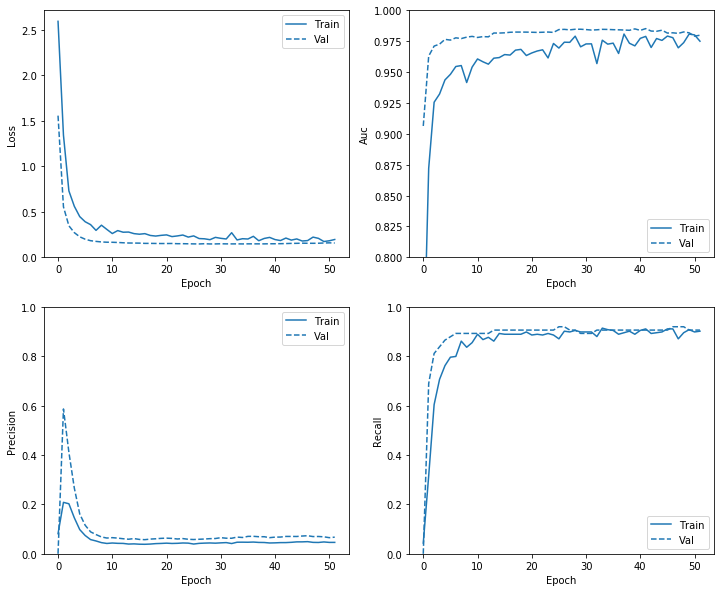

In [34]:
plot_metrics(weighted_history)

loss :  0.09064382941079087
tp :  87.0
fp :  1174.0
tn :  55693.0
fn :  8.0
accuracy :  0.9792493
precision :  0.06899286
recall :  0.9157895
auc :  0.98038137


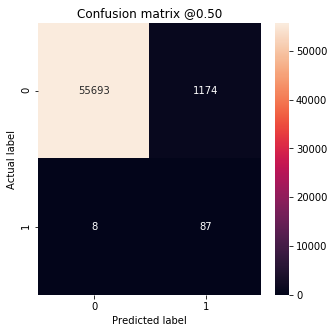

In [35]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

plot_cm(test_labels, test_predictions_weighted)

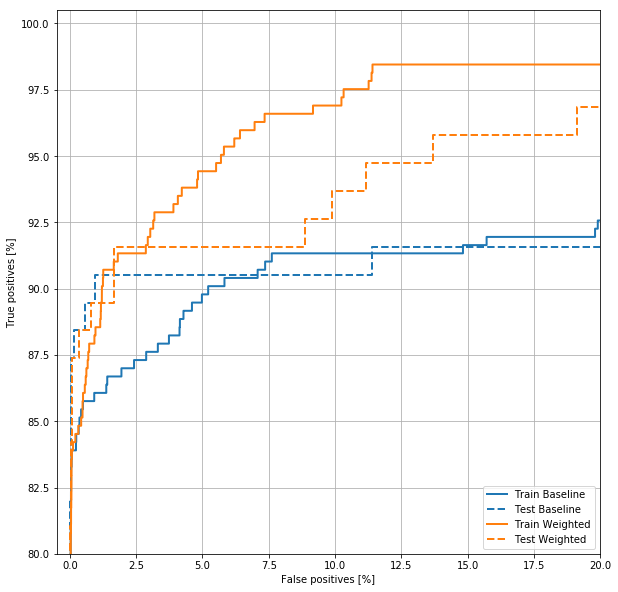

In [36]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [37]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [38]:
# Use numpy

In [39]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181953, 29)

In [40]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363906, 29)

In [41]:
resampled_model = build_model()
resampled_model.load_weights(initial_weights)

# 预测集并没有做balance
# Reset the bias to zero, since this dataset is balanced.
# output_layer = resampled_model.layers[-1] 
# output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    # These are not real epochs
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 363906 samples, validate on 45569 samples
Epoch 1/100
363906/363906 [==============================] - 4s 11us/sample - loss: 1.2953 - tp: 78937.0000 - fp: 1160.0000 - tn: 180793.0000 - fn: 103016.0000 - accuracy: 0.7137 - precision: 0.9855 - recall: 0.4338 - auc: 0.8298 - val_loss: 0.0297 - val_tp: 61.0000 - val_fp: 311.0000 - val_tn: 45184.0000 - val_fn: 13.0000 - val_accuracy: 0.9929 - val_precision: 0.1640 - val_recall: 0.8243 - val_auc: 0.9710
Epoch 2/100
363906/363906 [==============================] - 1s 4us/sample - loss: 0.3778 - tp: 148569.0000 - fp: 3877.0000 - tn: 178076.0000 - fn: 33384.0000 - accuracy: 0.8976 - precision: 0.9746 - recall: 0.8165 - auc: 0.9444 - val_loss: 0.0563 - val_tp: 66.0000 - val_fp: 656.0000 - val_tn: 44839.0000 - val_fn: 8.0000 - val_accuracy: 0.9854 - val_precision: 0.0914 - val_recall: 0.8919 - val_auc: 0.9782
Epoch 3/100
363906/363906 [==============================] - 1s 4us/sample - loss: 0.2942 - tp: 156309.0000 - fp: 5524.0000 - tn:

In [42]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07840689847544755
tp :  87.0
fp :  1044.0
tn :  55823.0
fn :  8.0
accuracy :  0.98153156
precision :  0.07692308
recall :  0.9157895
auc :  0.980417


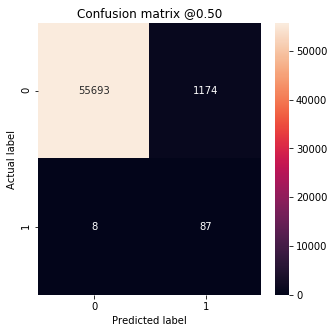

In [43]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)

plot_cm(test_labels, test_predictions_weighted)

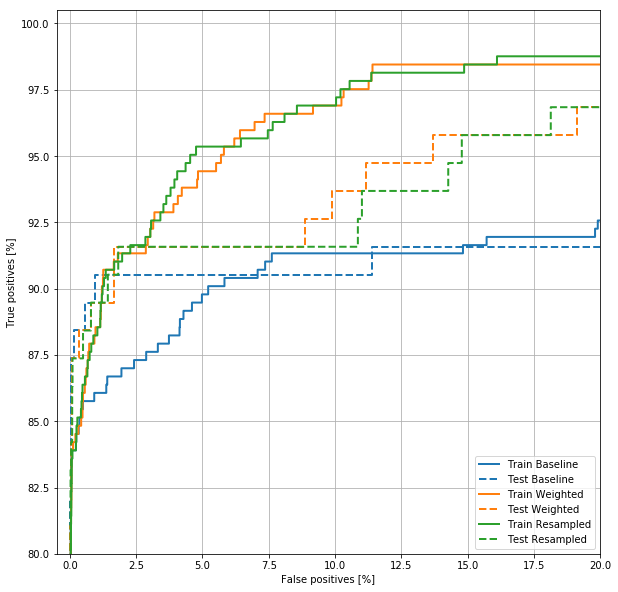

In [44]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

In [45]:
# Use tf.data 

In [46]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [47]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2) # 往队列里缓存2个batch，一般用于GPU

In [48]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.521484375


In [49]:
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

In [81]:
resampled_model = build_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
#output_layer = resampled_model.layers[-1] 
#output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Train for 20 steps, validate for 23 steps
Epoch 1/1000
20/20 [==============================] - 4s 194ms/step - loss: 2.2804 - tp: 2264.0000 - fp: 3401.0000 - tn: 17031.0000 - fn: 18264.0000 - accuracy: 0.4711 - precision: 0.3996 - recall: 0.1103 - auc: 0.2593 - val_loss: 0.3499 - val_tp: 7.0000 - val_fp: 3316.0000 - val_tn: 42168.0000 - val_fn: 78.0000 - val_accuracy: 0.9255 - val_precision: 0.0021 - val_recall: 0.0824 - val_auc: 0.3433
Epoch 2/1000
20/20 [==============================] - 1s 50ms/step - loss: 1.2717 - tp: 7491.0000 - fp: 3872.0000 - tn: 16694.0000 - fn: 12903.0000 - accuracy: 0.5905 - precision: 0.6592 - recall: 0.3673 - auc: 0.5143 - val_loss: 0.3597 - val_tp: 43.0000 - val_fp: 3805.0000 - val_tn: 41679.0000 - val_fn: 42.0000 - val_accuracy: 0.9156 - val_precision: 0.0112 - val_recall: 0.5059 - val_auc: 0.6560
Epoch 3/1000
20/20 [==============================] - 1s 62ms/step - loss: 0.8308 - tp: 11920.0000 - fp: 4082.0000 - tn: 16443.0000 - fn: 8515.0000 - accuracy

Epoch 00040: early stopping


In [84]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.08410903691616602
tp :  84.0
fp :  987.0
tn :  55877.0
fn :  14.0
accuracy :  0.9824269
precision :  0.078431375
recall :  0.85714287
auc :  0.9593542


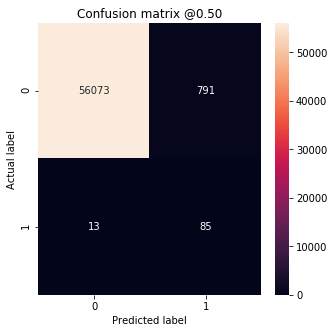

In [82]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)

plot_cm(test_labels, test_predictions_weighted)

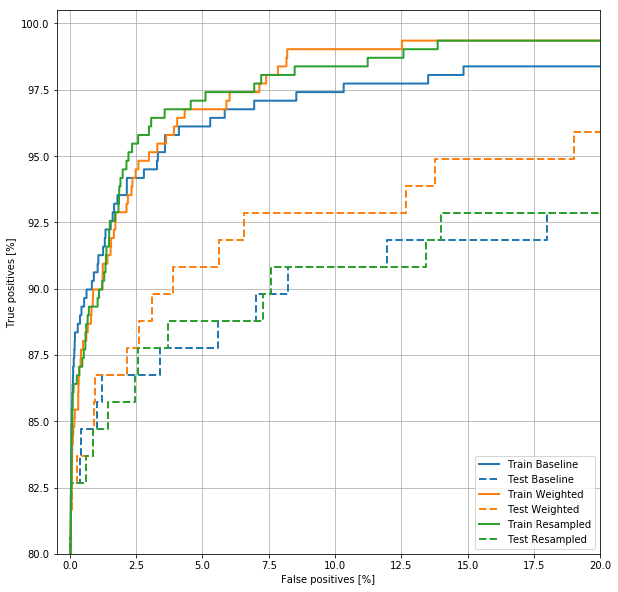

In [85]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')